In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import *
from torchsummary import summary
from torchdiffeq import odeint
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline
from lstm_models import LSTMModelB

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
I_train, I_test, *_ = load_data()

I_mu = I_train.mean(axis=0)
I_sigma = I_train.std(axis=0)

I_sc_train = (I_train - I_mu)/I_sigma
I_sc_test = (I_test - I_mu)/I_sigma

I_train = I_train.cpu()
I_test = I_test.cpu()

torques_sc_train = sio.loadmat('torque0_train.mat')
torques_sc_test = sio.loadmat('torque0_test.mat')

torques_sc_train = torch.from_numpy(torques_sc_train).float()[..., :50].to(device)
torques_sc_test = torch.from_numpy(torques_sc_test).float()[..., :50].to(device)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(30, 20)
        self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(10, 3)
        
        self.layer6 = nn.Linear(50, 50)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.mini_networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(30 + 3 * i, 30 + 2 * i),
                nn.Tanh(),
                nn.Dropout(p=0.1),
                nn.Linear(30 + 2 * i, 30 + i),
                nn.Tanh(),
                nn.Dropout(p=0.1),
                nn.Linear(30 + i, 30),
                nn.Tanh(),
                nn.Linear(30, 15),
                nn.Tanh(),
                nn.Linear(15, 3)
            ) for i in range(1, 50)
        ])
        
    def forward(self, input_data):
        x = self.tanh(self.layer1(input_data))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        
        t = x[:, None]
        
        for i in range(49):
            x = torch.cat((t.reshape(input_data.size(0), -1), input_data), axis=-1)
            x = self.mini_networks[i](x)
            t = torch.cat((t, x[:, None]), axis=1)

            x = t.mean(axis=-1)
        
        x = x + self.tanh(self.layer6(x))
            
        return x

In [5]:
net = torch.load('models/best_result_with_res_net.pt')

In [6]:
net.eval()
count = 0
total_loss = 0
loss_function = nn.MSELoss()

inputs_all = torch.cat((input_sc_train, input_sc_test))
torques_all = torch.cat((torques_sc_train, torques_sc_test))[..., :50]

for i in range(0, inputs_all.size(0), 10000):
    output = net(inputs_all[i:i+10000])[..., :50]
    total_loss += loss_function(output, torques_all[i:i+10000]).item()
    count += 1

print('MSE Loss on (train + test) =', total_loss/count)


MSE Loss on (train + test) = 0.001852333385613747


In [7]:
print('MSE Loss on test =', torch.nn.MSELoss()(torques_sc_test, net(I_sc_test)))

MSE Loss on test = tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


In [8]:
net.eval()

loss = 0
loss_function = nn.MSELoss()
count = 0

for i in range(0, I_sc_train.size(0), 10000):
    out = net(I_sc_train[i:i+10000])[..., :50]
    loss += loss_function(out, torques_sc_train[i:i+10000]).item()
    count += 1

print('MSE Loss on train =', loss/count)


MSE Loss on train = 0.0017095537124467747


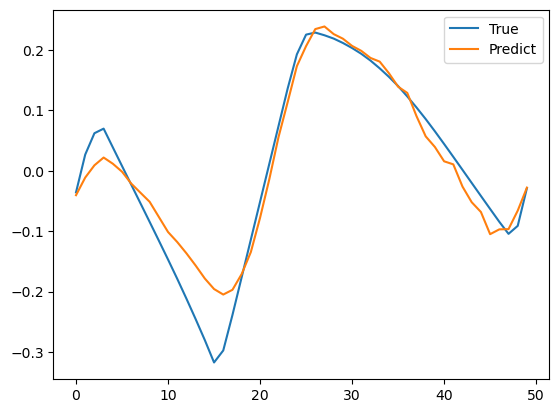

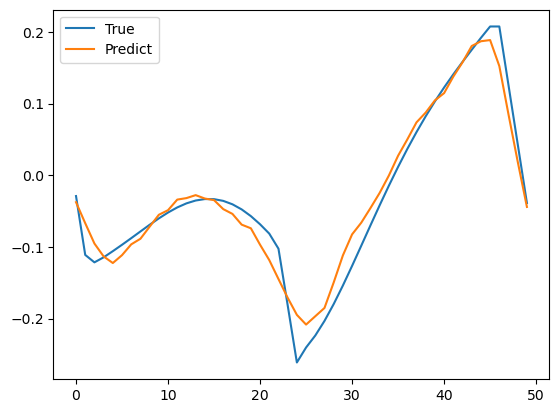

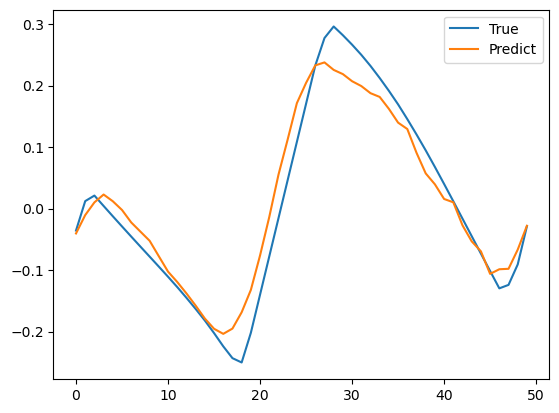

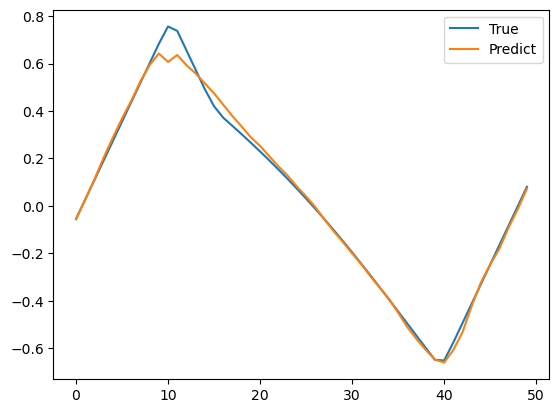

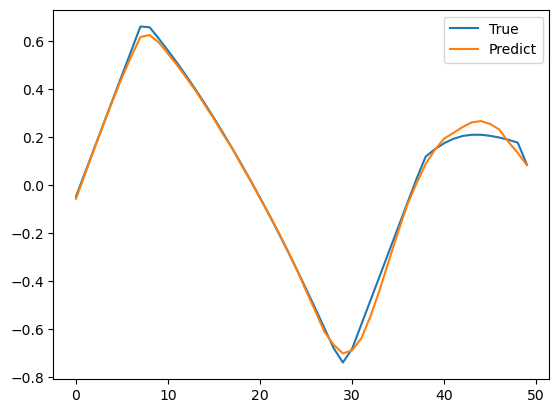

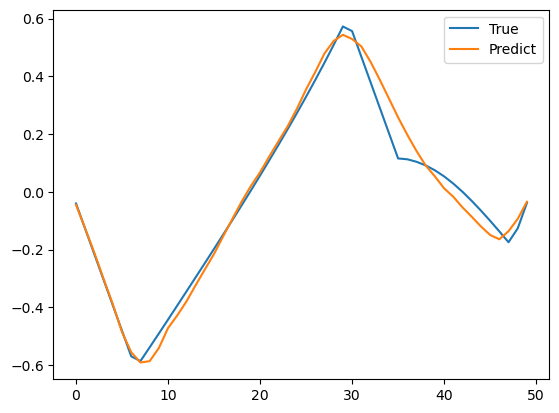

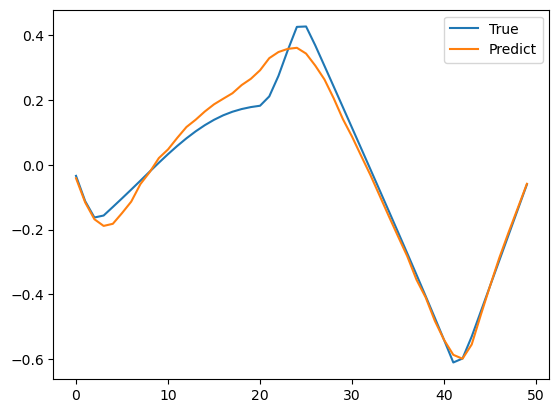

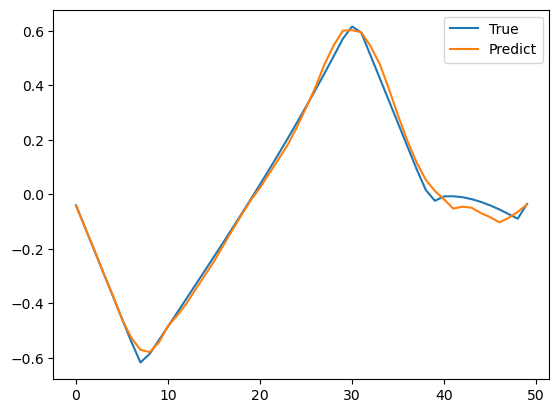

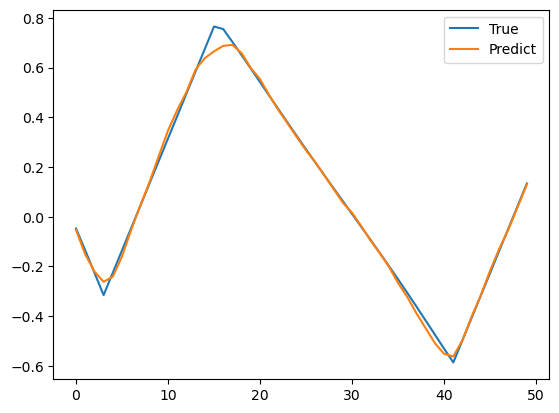

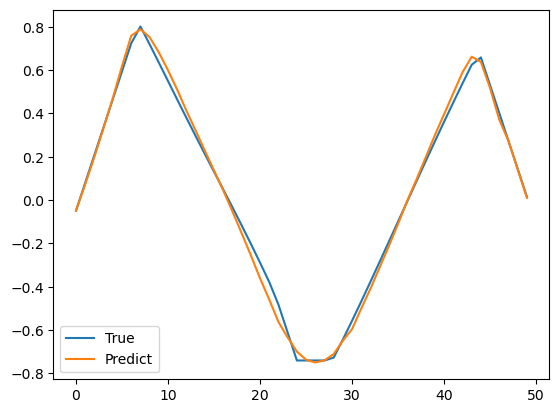

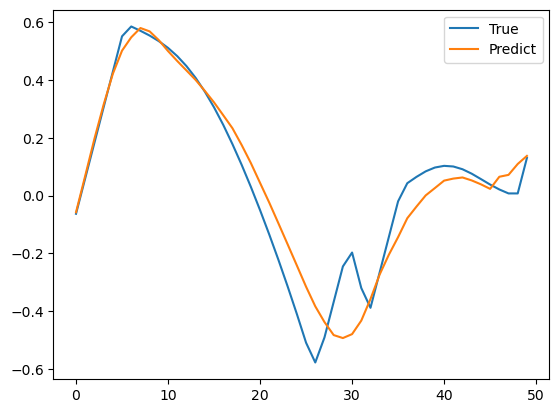

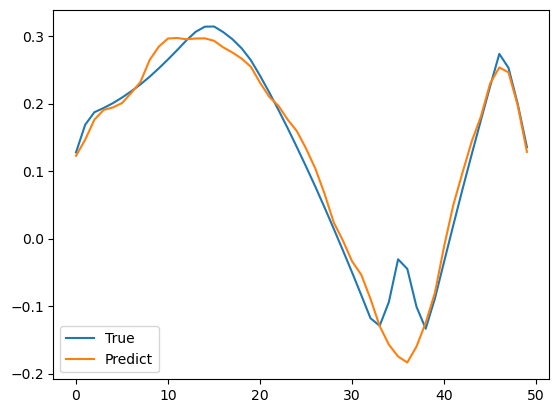

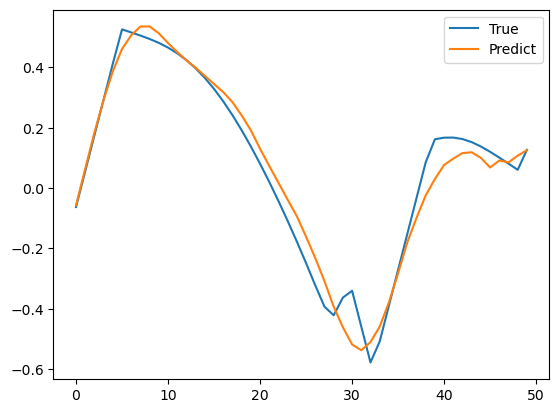

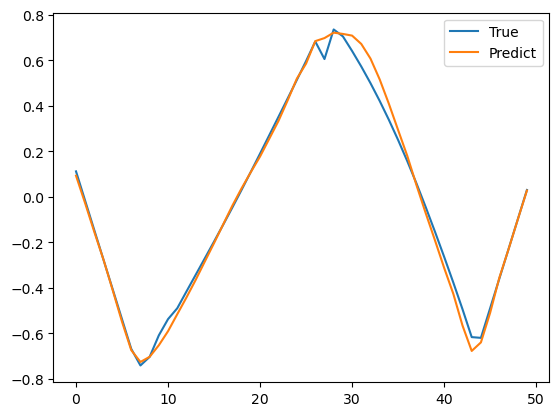

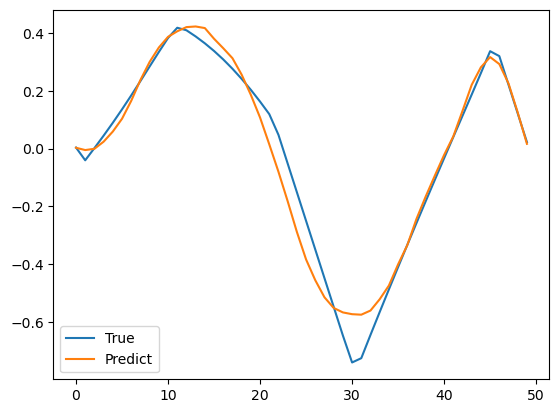

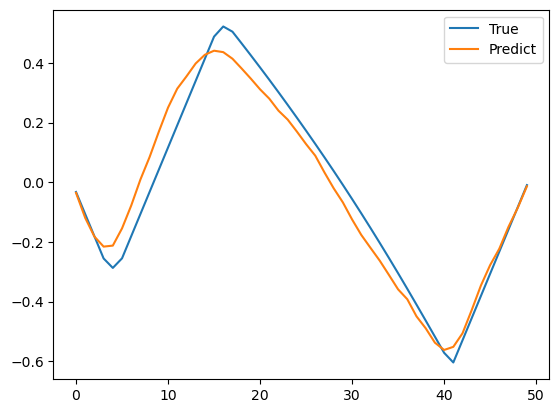

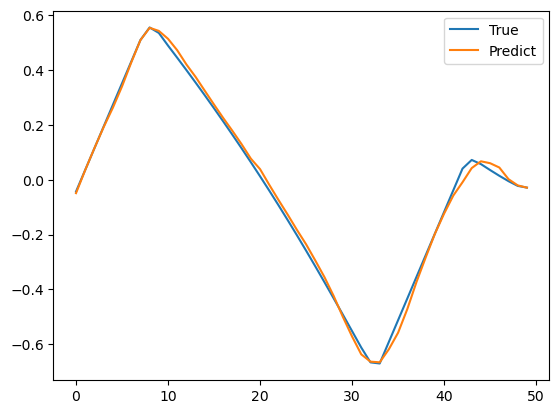

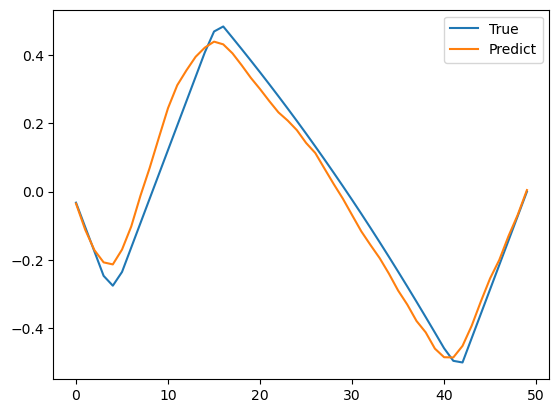

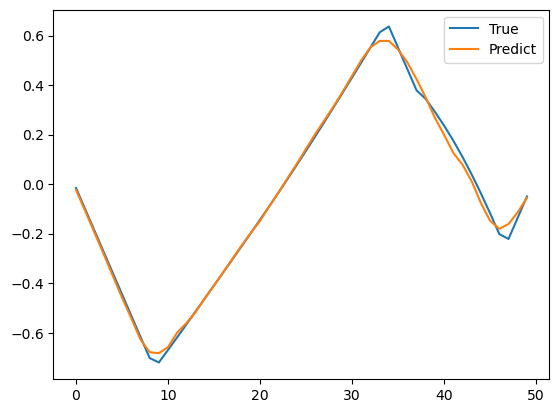

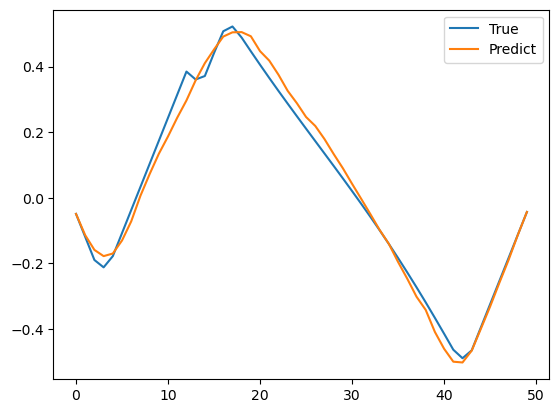

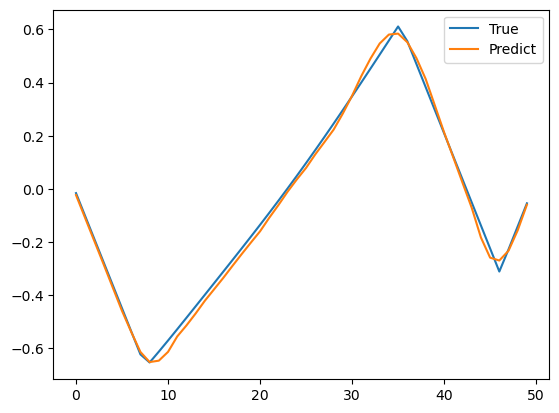

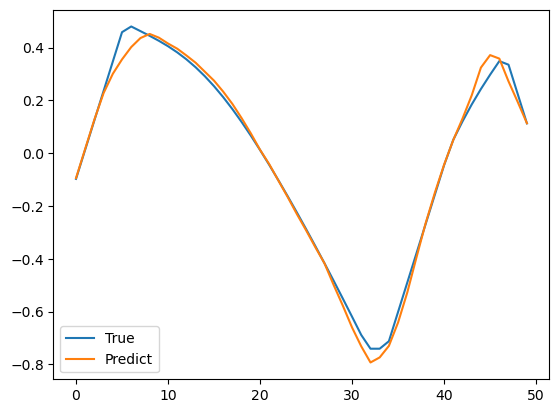

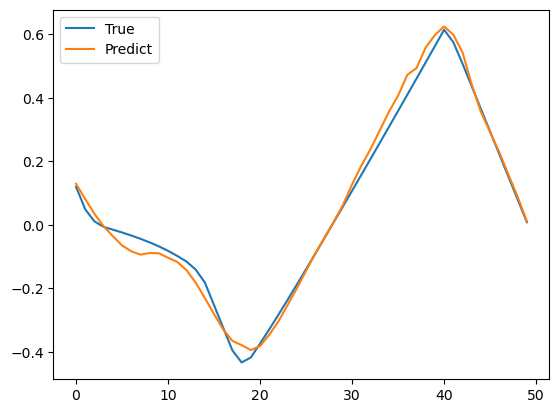

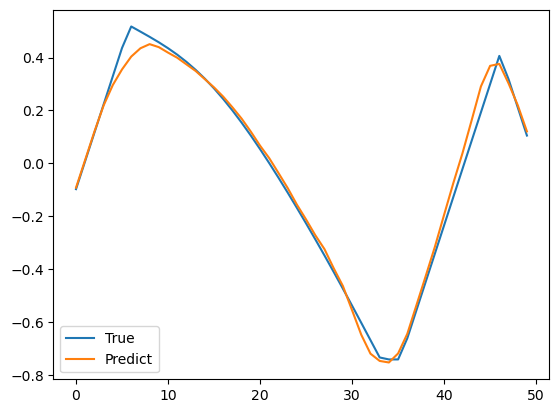

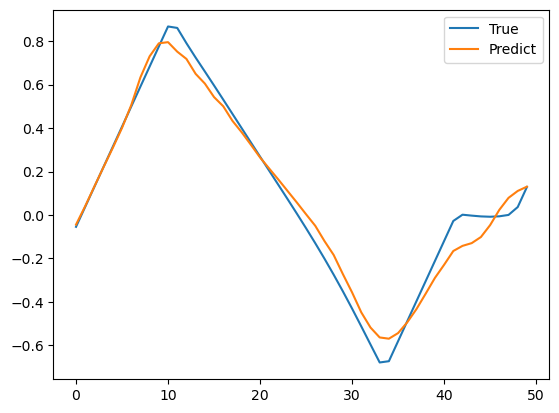

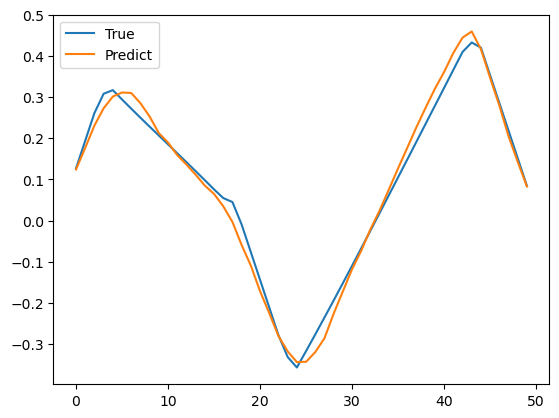

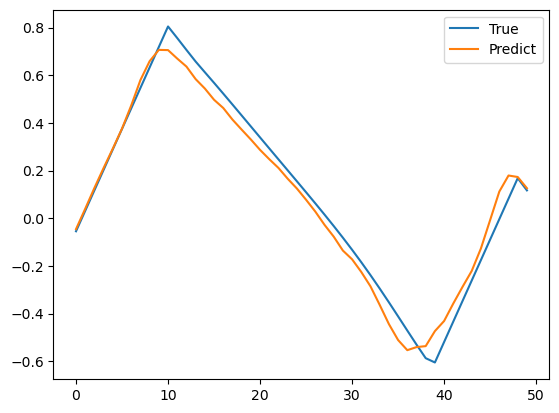

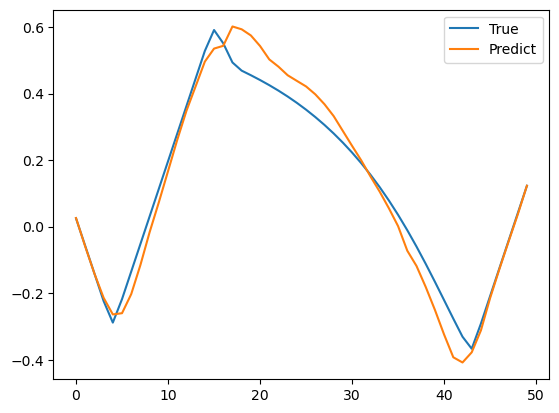

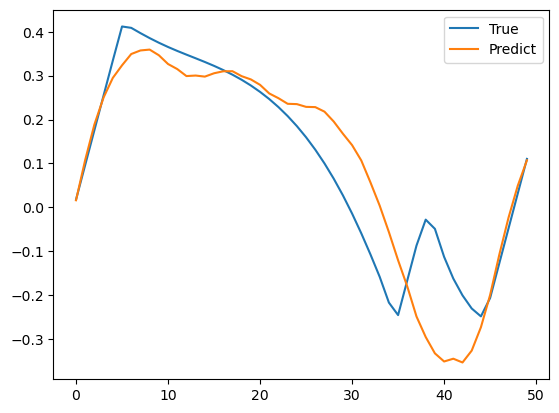

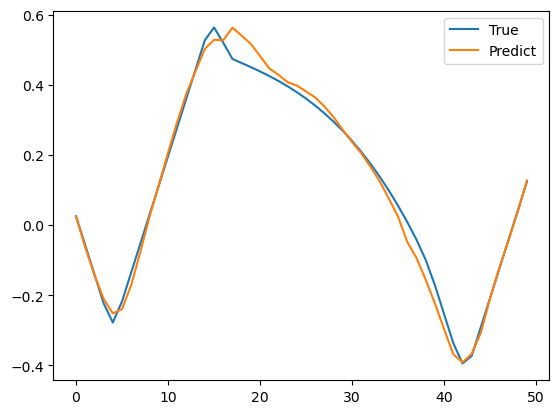

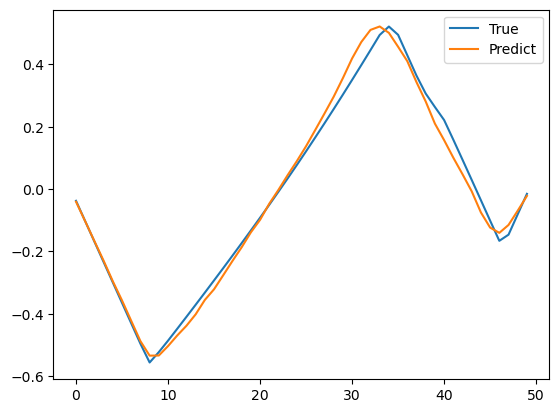

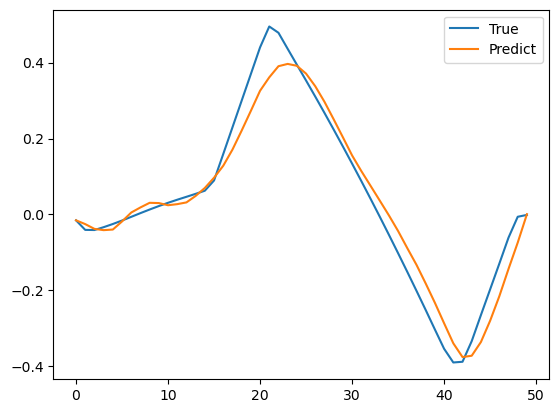

In [9]:
out = net(I_sc_test)[..., :50]

for i in range(32):
    plt.plot(torques_sc_test[i, ..., :50].cpu().detach(), label='True')
    plt.plot(out[i].cpu().detach(), label='Predict')
    plt.legend()
    plt.show()